In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container {width:90% !important;}</style>"))

In [2]:
%matplotlib notebook

from numpy import *
import os
from os import path
home = path.expanduser("~")

import matplotlib.pyplot as plt

# define plot style
width = 0.05
plotMarkerSize = 8
labelfontsize = 15
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6., 4.5]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.format'] = "pdf"

EPS = 1e-16  # a small number

# read in results from ideal hydro and with bulk pressure

In [3]:
working_path = os.getcwd()
results_path = os.path.dirname(working_path)
plots_path = path.join(os.path.dirname(working_path), "plots")

In [4]:
exercise_path_2 = "run_exercise_2" # ideal hydro
exercise_path_4 = "run_exercise_4" # hydro w/ bulk

In [5]:
def read_in_hadrons(exercise_path):
    with open(path.join(results_path, exercise_path, "hadron_list.dat")) as fp:
        line = fp.readline()  # read in the header
        npart_tot = 0
        nev = 0
        event_list = []
        while line:
            nparticles = int(line.split()[3])
            event_i = []
            for ipart in range(nparticles):
                line = fp.readline()
                event_i.append(array([float(i) for i in line.split()]))
            event_list.append(array(event_i))
            nev += 1
            npart_tot += nparticles
            #print("Event {} has {} particles".format(nev, nparticles))
            line = fp.readline()  # read in the header
    print("Read in total {0} events from {1}. Total particle number is {2}".format(nev, exercise_path, npart_tot))
    
    return nev, event_list

In [6]:
hadron_results_2 = read_in_hadrons(exercise_path_2)
hadron_results_4 = read_in_hadrons(exercise_path_4)

nev_2 = hadron_results_2[0]
nev_4 = hadron_results_4[0]

event_list_2 = hadron_results_2[1]
event_list_4 = hadron_results_4[1]

Read in total 10 events from run_exercise_2. Total particle number is 152822
Read in total 10 events from run_exercise_4. Total particle number is 193561


# calculate observables

In [7]:
class SimpleHistogram:
    """A simple histogram class"""
    def __init__(self, x_min, x_max, nx):
        self.x_min_ = x_min
        self.x_max_ = x_max
        self.nx_ = nx
        self.dx_ = (x_max - x_min)/nx
        self.bin_x_ = zeros(nx)
        for i in range(nx):
            self.bin_x_[i] = x_min + (i+0.5)*self.dx_
        self.bin_y_ = zeros(nx)
    
    def fill(self, x_in, val):
        idx = int((x_in - self.x_min_)/self.dx_)
        if idx >= 0 and idx < self.nx_:
            self.bin_y_[idx] += val

In [8]:
y_cut = 0.5

def calc_obs(pid, event_list, nev):
    
    pTSpectra   = SimpleHistogram(0.0, 3.0, 31)
    
    multi = 0
    
    for event_i in event_list:
        npart, ncol = event_i.shape
        for ipart in range(npart):
            if event_i[ipart][1] != pid: continue
            if event_i[ipart][3] > abs(event_i[ipart][6]):
                # compute the particle rapidity
                y = 0.5*log((event_i[ipart][3] + event_i[ipart][6])
                            /(event_i[ipart][3] - event_i[ipart][6] + EPS))
                # compute particle pT
                pT = sqrt(event_i[ipart][4]**2 + event_i[ipart][5]**2.)
                if y < y_cut and y > -y_cut:  # select the rapidity acceptance
                    pTSpectra.fill(pT, 1.)
                    multi +=1
                        
    # dN/2pi*pTdpTdy
    delta_y = 2.*y_cut
    delta_pT = pTSpectra.bin_x_[1] - pTSpectra.bin_x_[0]
    pTSpectra_err = sqrt(pTSpectra.bin_y_/nev)/(delta_y*delta_pT*2*math.pi);
    pTSpectra.bin_y_ /= (nev*delta_y*delta_pT*2*math.pi)   # divide spectra by dy and dpT
    
    # dN/dy
    dNdy = multi/(nev*delta_y)
    dNdy_err = sqrt(multi/nev)/delta_y;
    
    # mean pT
    mean_pT = sum(pTSpectra.bin_x_*pTSpectra.bin_y_)/sum(pTSpectra.bin_y_)

    return pTSpectra, pTSpectra_err, dNdy, dNdy_err, mean_pT

In [9]:
pid_list = [211, 321, 2212]

identified_obs_2 = {}
identified_obs_4 = {}

for pid in pid_list:
    
    identified_obs_2['{:d}'.format(pid)] = calc_obs(pid, event_list_2, nev_2)
    identified_obs_4['{:d}'.format(pid)] = calc_obs(pid, event_list_4, nev_4)

pi_obs_2 = identified_obs_2['211']
k_obs_2 = identified_obs_2['321']
p_obs_2 = identified_obs_2['2212']

pi_obs_4 = identified_obs_4['211']
k_obs_4 = identified_obs_4['321']
p_obs_4 = identified_obs_4['2212']

# compare results from ideal hydro and with bulk pressure

In [10]:
syst_name = "20-30% Pb-Pb@2.76 TeV"

<IPython.core.display.Javascript object>


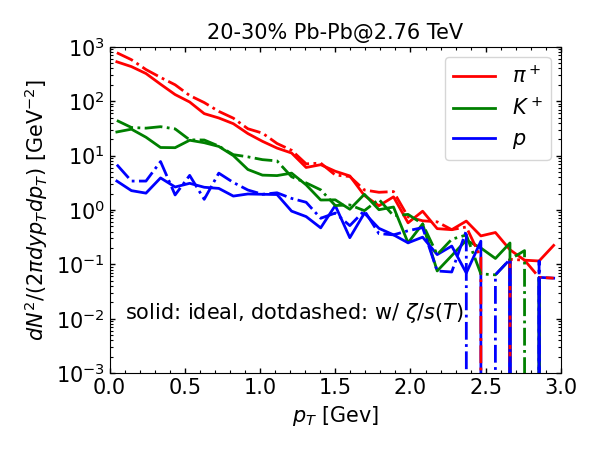

In [16]:
fig = plt.figure()

plt.plot(pi_obs_2[0].bin_x_, pi_obs_2[0].bin_y_/pi_obs_2[0].bin_x_, '-r', label=r'$\pi^+$')
plt.plot(k_obs_2[0].bin_x_, k_obs_2[0].bin_y_/k_obs_2[0].bin_x_, '-g', label=r'$K^+$')
plt.plot(p_obs_2[0].bin_x_, p_obs_2[0].bin_y_/p_obs_2[0].bin_x_, '-b', label=r'$p$')

plt.plot(pi_obs_4[0].bin_x_, pi_obs_4[0].bin_y_/pi_obs_4[0].bin_x_, '-.r')
plt.plot(k_obs_4[0].bin_x_, k_obs_4[0].bin_y_/k_obs_4[0].bin_x_, '-.g')
plt.plot(p_obs_4[0].bin_x_, p_obs_4[0].bin_y_/p_obs_4[0].bin_x_, '-.b')

plt.legend(loc="upper right")
plt.xlabel(r"$p_T$ [Gev]")
plt.ylabel(r"$dN^2/(2\pi{}dy p_T dp_T)$ [GeV$^{-2}$]")
plt.xlim([0, 3.])
plt.ylim([1.e-3, 1.e3])
plt.yscale("log")
plt.title(r"{}".format(syst_name), fontsize=labelfontsize)
plt.text(0.1, 1.e-2, r"solid: ideal, dotdashed: w/ $\zeta/s(T)$", fontsize=labelfontsize)
plt.tight_layout()

plt.savefig(path.join(plots_path, "{0}_plot_pT_spectra").format(exercise_path_4), bbox_inches='tight')

<IPython.core.display.Javascript object>


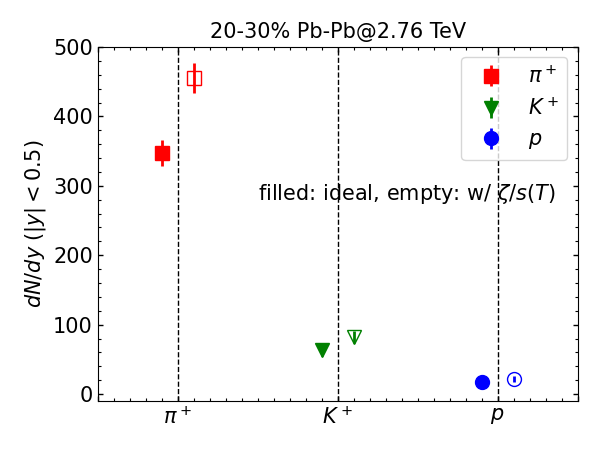

In [19]:
fig = plt.figure()

plt.axvline(x=0.0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=1.0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=2.0, color='k', linestyle='--', linewidth=1)

plt.errorbar(-0.1, pi_obs_2[2], yerr = pi_obs_2[3], fmt='s', color='r', markersize=10, label=r'$\pi^+$')
plt.errorbar(0.9, k_obs_2[2], yerr = k_obs_2[3], fmt='v', color='g', markersize=10, label=r'$K^+$')
plt.errorbar(1.9, p_obs_2[2], yerr = p_obs_2[3], fmt='o', color='b', markersize=10, label=r'$p$')

plt.errorbar(0.1, pi_obs_4[2], yerr = pi_obs_4[3], fmt='s', color='r', markersize=10, markerfacecolor='none')
plt.errorbar(1.1, k_obs_4[2], yerr = k_obs_4[3], fmt='v', color='g', markersize=10, markerfacecolor='none')
plt.errorbar(2.1, p_obs_4[2], yerr = p_obs_4[3], fmt='o', color='b', markersize=10, markerfacecolor='none')

plt.legend(loc=0, ncol=1)
axes=plt.gca()
axes.set_xticks([-0.5,0,1,2,2.5])
axes.set_xticklabels(["", r"$\pi^+$", r"$K^+$", r"$p$", ""])
plt.ylabel(r"$dN/dy\; (|y|<0.5)$")
#plt.ylim([-30, 370])
plt.title(r"{}".format(syst_name), fontsize=labelfontsize)
plt.text(0.5, 280, r"filled: ideal, empty: w/ $\zeta/s(T)$", fontsize=labelfontsize)
plt.tight_layout()

plt.savefig(path.join(plots_path, "{0}_plot_multiplicity").format(exercise_path_4), bbox_inches='tight')

<IPython.core.display.Javascript object>


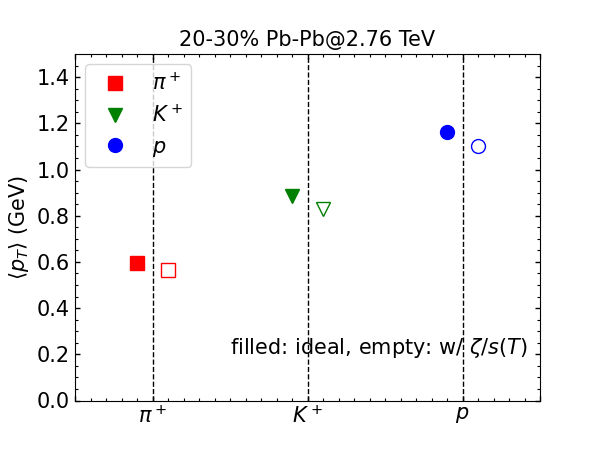

In [18]:
fig = plt.figure()

plt.axvline(x=0.0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=1.0, color='k', linestyle='--', linewidth=1)
plt.axvline(x=2.0, color='k', linestyle='--', linewidth=1)

plt.plot(-0.1, pi_obs_2[4], 's', color='r', markersize=10, label=r'$\pi^+$')
plt.plot(0.9, k_obs_2[4], 'v', color='g', markersize=10, label=r'$K^+$')
plt.plot(1.9, p_obs_2[4], 'o', color='b', markersize=10, label=r'$p$')

plt.plot(0.1, pi_obs_4[4], 's', color='r', markersize=10, markerfacecolor='none')
plt.plot(1.1, k_obs_4[4], 'v', color='g', markersize=10, markerfacecolor='none')
plt.plot(2.1, p_obs_4[4], 'o', color='b', markersize=10, markerfacecolor='none')

plt.legend(loc='upper left', ncol=1)
axes=plt.gca()
axes.set_xticks([-0.5,0,1,2,2.5])
axes.set_xticklabels(["", r"$\pi^+$", r"$K^+$", r"$p$", ""])
plt.ylabel(r"$\langle p_T \rangle$ (GeV)")
plt.ylim([0.0, 1.5])
plt.title(r"{}".format(syst_name), fontsize=labelfontsize)
plt.text(0.5, 0.2, r"filled: ideal, empty: w/ $\zeta/s(T)$", fontsize=labelfontsize)


plt.savefig(path.join(plots_path, "{0}_plot_mean_pT").format(exercise_path_4), bbox_inches='tight')